In [65]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn import metrics

# Data Acquisition

In [2]:
df = pd.read_csv ('https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv')
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,...,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,...,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,...,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


In [3]:
df.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [4]:
df.shape

(221738, 40)

In [5]:
# drop columns with no prediciton value. 
df.drop(['X','Y','OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'SDOTCOLNUM', 'PEDROWNOTGRNT',  'INCDATE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'ADDRTYPE', 'JUNCTIONTYPE'], axis = 1,inplace=True)

# Data Cleanup

In [6]:
# count total accidents grouped by severity. 
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    137776
Injury Collision                   58842
Unknown                            21657
Serious Injury Collision            3111
Fatality Collision                   352
Name: SEVERITYDESC, dtype: int64

In [7]:
# drop "Unknown" rows for severity and format to integer 
df['SEVERITYCODE'].replace("0", np.nan, inplace = True)
df.dropna(subset=['SEVERITYCODE'], axis=0, inplace = True)
df['SEVERITYCODE'].replace("1", 1, inplace = True)
df['SEVERITYCODE'].replace("2", 2, inplace = True)
df['SEVERITYCODE'].replace("3", 4, inplace = True)
df['SEVERITYCODE'].replace("2b", 3, inplace = True)
df['SEVERITYCODE'].astype(int)
df.shape

(200081, 12)

In [8]:
df['SEVERITYCODE'].value_counts()

1    137776
2     58842
3      3111
4       352
Name: SEVERITYCODE, dtype: int64

In [9]:
# format date and time column. 
df['INCDTTM'] = pd.to_datetime(df['INCDTTM'])

### Format categorical into dummy variables

In [10]:
df['SPEEDING'].replace(np.nan, 0, inplace = True)
df['SPEEDING'].replace("Y", 1, inplace = True)
df['SPEEDING'].astype(int)
df['SPEEDING'].unique()

array([0, 1])

In [11]:
df['PEDCYLCOUNT'].replace(2, 1, inplace = True)
df.rename(columns={'PEDCYLCOUNT': 'CYCLIST'}, inplace=True)
df['CYCLIST'].astype(int)
df['CYCLIST'].unique()

array([0, 1])

In [12]:
df['INATTENTIONIND'].replace(np.nan, 0, inplace = True)
df['INATTENTIONIND'].replace("Y", 1, inplace = True)
df['INATTENTIONIND'].astype(int)
df['INATTENTIONIND'].unique()

array([0, 1])

In [13]:
df['PEDCOUNT'].replace(2, 1, inplace = True)
df['PEDCOUNT'].replace(3, 1, inplace = True)
df['PEDCOUNT'].replace(4, 1, inplace = True)
df['PEDCOUNT'].replace(5, 1, inplace = True)
df['PEDCOUNT'].replace(6, 1, inplace = True)
df.rename(columns={'PEDCOUNT': 'PEDESTRIAN'}, inplace=True)
df['PEDESTRIAN'].astype(int)
df['PEDESTRIAN'].unique()

array([0, 1])

In [14]:
df['UNDERINFL'].replace(np.nan, 0, inplace = True)
df['UNDERINFL'].replace("Y", 1, inplace = True)
df['UNDERINFL'].replace("N", 0, inplace = True)
df['UNDERINFL'].replace("1", 1, inplace = True)
df['UNDERINFL'].replace("0", 0, inplace = True)
df['UNDERINFL'].astype(int)
df['UNDERINFL'].unique()

array([0, 1])

In [15]:
df['WEATHER'].replace('Unknown', np.nan, inplace = True)
df['WEATHER'].replace('Other', np.nan, inplace = True)
df.rename(columns={'WEATHER': 'W'}, inplace=True)
df['W'].unique()

array(['Clear', 'Raining', 'Overcast', nan, 'Snowing',
       'Sleet/Hail/Freezing Rain', 'Fog/Smog/Smoke', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy', 'Blowing Snow'], dtype=object)

In [16]:
df['ROADCOND'].replace('Unknown', np.nan, inplace = True)
df['ROADCOND'].replace('Other', np.nan, inplace = True)
df.rename(columns={'ROADCOND': 'road'}, inplace=True)
df['road'].unique()

array(['Dry', 'Wet', 'Ice', nan, 'Snow/Slush', 'Standing Water',
       'Sand/Mud/Dirt', 'Oil'], dtype=object)

In [17]:
df['LIGHTCOND'].replace('Unknown', np.nan, inplace = True)
df['LIGHTCOND'].replace('Other', np.nan, inplace = True)
df.rename(columns={'LIGHTCOND': 'light'}, inplace=True)
df['light'].unique()

array(['Daylight', 'Dusk', 'Dark - Street Lights On', nan, 'Dawn',
       'Dark - No Street Lights', 'Dark - Street Lights Off',
       'Dark - Unknown Lighting'], dtype=object)

In [18]:
df_dummies = pd.get_dummies(df, columns=['road', 'W', 'light' ])
df_dummies.head()

,LOCATION,SEVERITYCODE,SEVERITYDESC,PEDESTRIAN,CYCLIST,INCDTTM,INATTENTIONIND,UNDERINFL,SPEEDING,road_Dry,...,W_Severe Crosswind,W_Sleet/Hail/Freezing Rain,W_Snowing,light_Dark - No Street Lights,light_Dark - Street Lights Off,light_Dark - Street Lights On,light_Dark - Unknown Lighting,light_Dawn,light_Daylight,light_Dusk
0,17TH AVE SW AND SW ROXBURY ST,1,Property Damage Only Collision,0,0,2020-01-19 09:01:00,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,1,Property Damage Only Collision,0,0,2005-04-11 18:31:00,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,2,Injury Collision,0,0,2013-03-31 02:09:00,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,11TH AVE E AND E JOHN ST,2,Injury Collision,1,0,2020-01-06 17:55:00,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,2,Injury Collision,0,0,2009-12-25 19:00:00,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [19]:
df_dummies.dtypes

LOCATION                                  object
SEVERITYCODE                               int64
SEVERITYDESC                              object
PEDESTRIAN                                 int64
CYCLIST                                    int64
INCDTTM                           datetime64[ns]
INATTENTIONIND                             int64
UNDERINFL                                  int64
SPEEDING                                   int64
road_Dry                                   uint8
road_Ice                                   uint8
road_Oil                                   uint8
road_Sand/Mud/Dirt                         uint8
road_Snow/Slush                            uint8
road_Standing Water                        uint8
road_Wet                                   uint8
W_Blowing Sand/Dirt                        uint8
W_Blowing Snow                             uint8
W_Clear                                    uint8
W_Fog/Smog/Smoke                           uint8
W_Overcast          

# Balancing the Dataset

In [20]:
df_dummies['SEVERITYDESC'].value_counts()

Property Damage Only Collision    137776
Injury Collision                   58842
Serious Injury Collision            3111
Fatality Collision                   352
Name: SEVERITYDESC, dtype: int64

Because the Dataset heavily oversamples the category "Property Damage Only Collision" and "Injury Collision" over serious injury and fatality collisions, we will downsample these categories and upsample the fatality collisions to be able to work with a balanced dataset. 

In [21]:
# downsampeling "Property Damage Only Collision" and "Injury Collision"
df_damage = df_dummies[df.SEVERITYCODE==1]
df_injury = df_dummies[df.SEVERITYCODE==2]
df_damage_downsampled = resample(df_damage, replace=False, n_samples=3111, random_state=123)
df_injury_downsampled = resample(df_injury, replace=False, n_samples=3111, random_state=123)
df_downsampled = pd.concat([df_damage_downsampled, df_injury_downsampled])

In [22]:
# upsampeling "Fatality Collision"
df_fatalities = df_dummies[df.SEVERITYCODE==4]
df_serious = df_dummies[df.SEVERITYCODE==3]
df_fatalities_upsampled = resample(df_fatalities, replace=True, n_samples=3111,random_state=123)
df_balanced = pd.concat([df_downsampled, df_serious, df_fatalities_upsampled])

In [23]:
df_balanced['SEVERITYDESC'].value_counts()

Fatality Collision                3111
Serious Injury Collision          3111
Property Damage Only Collision    3111
Injury Collision                  3111
Name: SEVERITYDESC, dtype: int64

# Training the Models

In [40]:
y = df_balanced['SEVERITYCODE'].values
X = df_balanced[['PEDESTRIAN', 'CYCLIST', 'INATTENTIONIND', 'UNDERINFL', 'SPEEDING', 'road_Dry', 'road_Ice', 'road_Oil', 'road_Sand/Mud/Dirt', 'road_Snow/Slush','road_Standing Water', 'road_Wet', 'W_Blowing Sand/Dirt', 'W_Blowing Snow', 'W_Clear', 'W_Fog/Smog/Smoke', 'W_Overcast', 'W_Partly Cloudy', 'W_Raining', 'W_Severe Crosswind', 'W_Sleet/Hail/Freezing Rain', 'W_Snowing', 'light_Dark - No Street Lights', 'light_Dark - Street Lights Off', 'light_Dark - Street Lights On', 'light_Dark - Unknown Lighting', 'light_Dawn', 'light_Daylight', 'light_Dusk']] .values

In [41]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (9955, 29) (9955,)
Test set: (2489, 29) (2489,)


### K-Nearest Neighbour

In [45]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.37163519, 0.34511852, 0.3865006 , 0.38891121, 0.4102049 ,
       0.4214544 , 0.42989152, 0.43993572, 0.44877461, 0.43792688,
       0.44154279, 0.44033748, 0.4351145 , 0.44073925, 0.43471274,
       0.446364  , 0.4451587 , 0.45239052, 0.44395339])

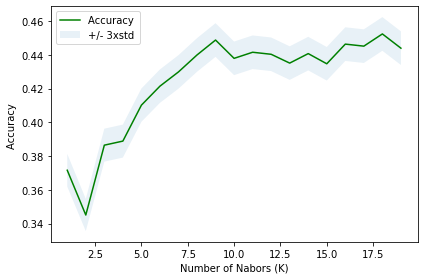

In [46]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [60]:
k = 9 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat_neigh = neigh.predict(X_test)

### Decision Tree

In [61]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
drugTree.fit(X_train,y_train)
yhat_tree = drugTree.predict(X_test)

### Logistic Regression

In [62]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat_lr = LR.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Support Vector Machine

In [64]:
SVM = svm.SVC(kernel='rbf')
SVM.fit(X_train, y_train) 
yhat_svm = SVM.predict(X_test)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


# Evaluation